# Preprocessing and Feature Engineering


### Importing packages


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

### Loading data


In [33]:
data = pd.read_csv("consumption_and_temperatures.csv")
data.tail()

,timestamp,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature
58459,2023-12-31 19:00:00+00:00,5608.067736,-4.7,4962.057148,4.1,3837.204332,-3.7,2806.182692,-6.5,2224.449164,6.3
58460,2023-12-31 20:00:00+00:00,5469.722792,-4.6,4864.162484,4.7,3773.021260,-3.6,2764.928700,-6.4,2175.957992,6.3
58461,2023-12-31 21:00:00+00:00,5321.221040,-4.5,4793.361440,4.6,3725.022064,-4.2,2738.213476,-6.4,2137.724404,6.2
58462,2023-12-31 22:00:00+00:00,5222.770756,-4.5,4742.807424,4.6,3668.956000,-4.2,2699.056760,-6.5,2110.928436,5.7
58463,2023-12-31 23:00:00+00:00,5210.969016,-4.4,4719.826460,4.4,3657.079824,-4.0,2696.672540,-6.6,2100.524368,5.7


## Preprocessing


### Checking for holes


In [34]:
data.isna().sum()

timestamp          0
NO1_consumption    0
NO1_temperature    0
NO2_consumption    0
NO2_temperature    0
NO3_consumption    0
NO3_temperature    0
NO4_consumption    0
NO4_temperature    0
NO5_consumption    0
NO5_temperature    0
dtype: int64

### Converting timestamp to datetime and set as index


In [35]:
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.set_index("timestamp", inplace=True)
data.head()

,NO1_consumption,NO1_temperature,NO2_consumption,NO2_temperature,NO3_consumption,NO3_temperature,NO4_consumption,NO4_temperature,NO5_consumption,NO5_temperature
timestamp,,,,,,,,,,
2017-05-01 00:00:00+00:00,3325.431995,2.1,3534.588,5.0,2674.838,5.5,2061.209,0.2,1609.089,3.9
2017-05-01 01:00:00+00:00,3344.690998,1.8,3560.209,4.1,2678.188,4.0,2045.436,0.1,1623.485,3.2
2017-05-01 02:00:00+00:00,3398.359002,3.2,3596.149,3.1,2678.341,3.7,2020.007,0.1,1634.128,2.7
2017-05-01 03:00:00+00:00,3430.220001,3.6,3594.042,2.3,2684.172,3.2,2021.920,0.1,1647.906,2.3
2017-05-01 04:00:00+00:00,3606.750000,3.4,3665.091,2.6,2733.345,2.7,2045.913,0.1,1679.176,2.3


### Splitting temperature and consumption


In [36]:
temp_features = [
    "NO1_temperature",
    "NO2_temperature",
    "NO3_temperature",
    "NO4_temperature",
    "NO5_temperature",
]

cons_features = [
    "NO1_consumption",
    "NO2_consumption",
    "NO3_consumption",
    "NO4_consumption",
    "NO5_consumption",
]

temp = data[temp_features]
cons = data[cons_features]

temp.head()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature
timestamp,,,,,
2017-05-01 00:00:00+00:00,2.1,5.0,5.5,0.2,3.9
2017-05-01 01:00:00+00:00,1.8,4.1,4.0,0.1,3.2
2017-05-01 02:00:00+00:00,3.2,3.1,3.7,0.1,2.7
2017-05-01 03:00:00+00:00,3.6,2.3,3.2,0.1,2.3
2017-05-01 04:00:00+00:00,3.4,2.6,2.7,0.1,2.3


### Plotting data


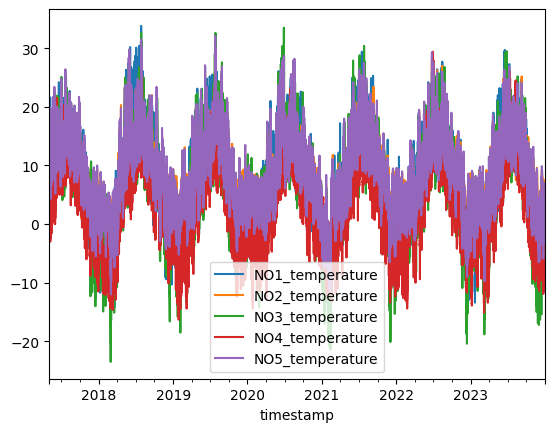

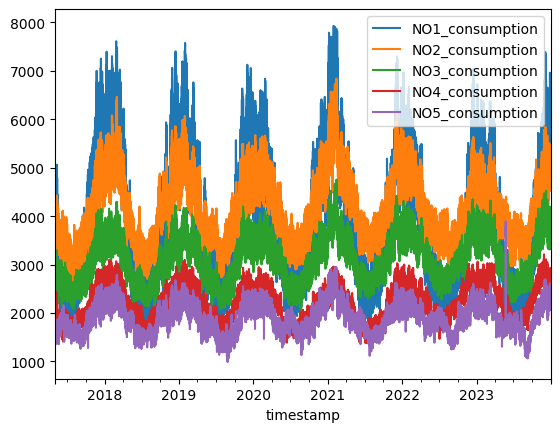

In [37]:
temp.plot()
cons.plot()
plt.show()

### Identifying spikes and replacing with holes


In [38]:
def remove_spikes(data, threshold=3.2):
    tensor = torch.tensor(data.values)
    mean = tensor.mean()
    std = tensor.std()
    z_scores = (tensor - mean) / std
    spike_indices = (z_scores > threshold) | (z_scores < -threshold)
    tensor[spike_indices] = float("nan")
    return pd.DataFrame(tensor, index=data.index, columns=data.columns)


temp = remove_spikes(temp)
cons = remove_spikes(cons)
temp.isna().sum(), cons.isna().sum()

(NO1_temperature     17
 NO2_temperature      6
 NO3_temperature    243
 NO4_temperature      0
 NO5_temperature      7
 dtype: int64,
 NO1_consumption    1129
 NO2_consumption       2
 NO3_consumption       0
 NO4_consumption       0
 NO5_consumption       0
 dtype: int64)

### Replacing holes with interpolation


In [39]:
temp = temp.interpolate()
cons = cons.interpolate()
temp.isna().sum(), temp.isna().sum()

(NO1_temperature    0
 NO2_temperature    0
 NO3_temperature    0
 NO4_temperature    0
 NO5_temperature    0
 dtype: int64,
 NO1_temperature    0
 NO2_temperature    0
 NO3_temperature    0
 NO4_temperature    0
 NO5_temperature    0
 dtype: int64)

### Plotting without spikes


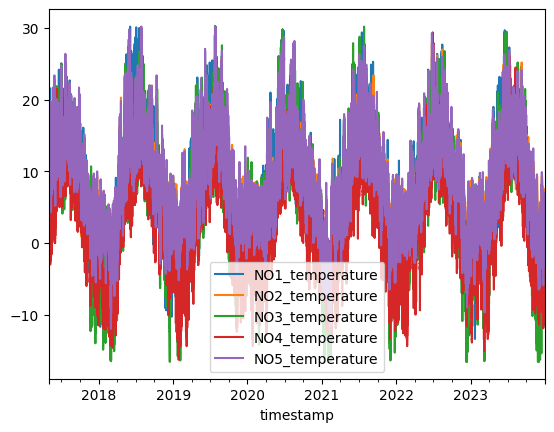

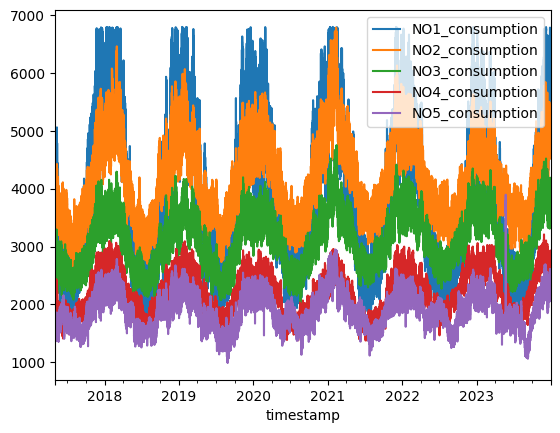

In [40]:
temp.plot()
cons.plot()
plt.show()

### Merging data without spikes


In [41]:
data = pd.concat([temp, cons], axis=1)
data.head()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption
timestamp,,,,,,,,,,
2017-05-01 00:00:00+00:00,2.1,5.0,5.5,0.2,3.9,3325.431995,3534.588,2674.838,2061.209,1609.089
2017-05-01 01:00:00+00:00,1.8,4.1,4.0,0.1,3.2,3344.690998,3560.209,2678.188,2045.436,1623.485
2017-05-01 02:00:00+00:00,3.2,3.1,3.7,0.1,2.7,3398.359002,3596.149,2678.341,2020.007,1634.128
2017-05-01 03:00:00+00:00,3.6,2.3,3.2,0.1,2.3,3430.220001,3594.042,2684.172,2021.920,1647.906
2017-05-01 04:00:00+00:00,3.4,2.6,2.7,0.1,2.3,3606.750000,3665.091,2733.345,2045.913,1679.176


### Splitting data into training, validation and testing data


In [59]:
train, test = train_test_split(data, test_size=0.2, train_size=0.8, shuffle=False)
train, val = train_test_split(train, test_size=0.25, shuffle=False)

val_weather = val.drop(cons_features, axis=1)
test_weather = test.drop(cons_features, axis=1)

weather = pd.concat([val_weather, test_weather])

weather.to_csv("weather.csv", index=True)  # saving future weather data

val = val.drop(temp_features, axis=1)
test = test.drop(temp_features, axis=1)

val.to_csv("val.csv", index=True)
test.to_csv("test.csv", index=True)

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption
timestamp,,,,,,,,,,
2021-05-01 14:00:00+00:00,12.7,8.4,5.5,-1.0,9.2,3509.544310,4084.631228,3132.595610,2079.582551,1783.934952
2021-05-01 15:00:00+00:00,11.5,8.2,6.0,-0.7,8.4,3556.168956,4169.236425,3154.855402,2084.744492,1804.042144
2021-05-01 16:00:00+00:00,10.9,8.1,6.6,-0.3,8.3,3612.004329,4224.864772,3150.682567,2088.385347,1807.236870
2021-05-01 17:00:00+00:00,10.4,7.9,6.0,-0.3,8.8,3635.319719,4233.985399,3152.845192,2095.634114,1807.709386
2021-05-01 18:00:00+00:00,8.5,7.3,5.7,-1.1,9.3,3606.846466,4228.019012,3139.657613,2096.165736,1797.413531
...,...,...,...,...,...,...,...,...,...,...
2022-08-31 14:00:00+00:00,19.6,17.9,13.1,9.0,18.3,2889.940248,3473.077036,2978.573621,2133.874625,1558.736073
2022-08-31 15:00:00+00:00,19.6,17.4,13.4,8.9,19.1,2844.237028,3414.602942,2960.966690,2119.620070,1540.890859
2022-08-31 16:00:00+00:00,19.7,17.5,12.7,8.4,18.5,2777.835375,3388.338129,2948.369883,2110.898402,1530.530739


### Normalization


In [48]:
# only normalize the training set
temp = train[temp_features]
cons = train[cons_features]

# save normalization parameters to transform back to original scale:
temp_tensor = torch.tensor(temp.values)
cons_tensor = torch.tensor(cons.values)

p, eps = (2, 1e-12)

norm_params = {"temperature": (p, eps), "consumption": (p, eps)}

torch.save(norm_params, "normalization_params.pt")

temp_norm = F.normalize(input=temp_tensor, dim=0, p=p, eps=eps)
cons_norm = F.normalize(input=cons_tensor, dim=0, p=p, eps=eps)

temp = pd.DataFrame(temp_norm, index=temp.index, columns=temp.columns)
cons = pd.DataFrame(cons_norm, index=cons.index, columns=cons.columns)

cons

,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption
timestamp,,,,,
2017-05-01 00:00:00+00:00,0.004132,0.004436,0.004594,0.004982,0.004441
2017-05-01 01:00:00+00:00,0.004155,0.004468,0.004600,0.004944,0.004481
2017-05-01 02:00:00+00:00,0.004222,0.004513,0.004600,0.004883,0.004510
2017-05-01 03:00:00+00:00,0.004262,0.004510,0.004611,0.004887,0.004548
2017-05-01 04:00:00+00:00,0.004481,0.004600,0.004695,0.004945,0.004634
...,...,...,...,...,...
2021-05-01 09:00:00+00:00,0.004617,0.005396,0.005585,0.005129,0.005055
2021-05-01 10:00:00+00:00,0.004510,0.005333,0.005518,0.005102,0.005008
2021-05-01 11:00:00+00:00,0.004433,0.005218,0.005461,0.005060,0.004953


### Plotting normalized data


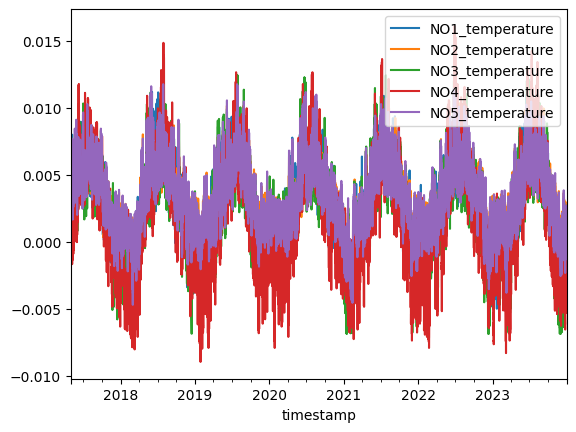

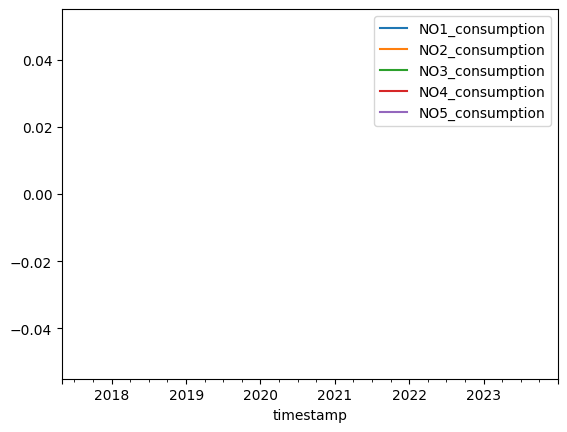

In [44]:
temp.plot()
cons.plot()
plt.show()

### Updating training data to normalized version and inserting future weather data


In [50]:
train = pd.concat([temp, cons], axis=1)
train = pd.concat([train, val_only_weather, test_only_weather], axis=0)
train

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption
timestamp,,,,,,,,,,
2017-05-01 00:00:00+00:00,0.001028,0.002611,0.002990,0.000147,0.001999,0.004132,0.004436,0.004594,0.004982,0.004441
2017-05-01 01:00:00+00:00,0.000881,0.002141,0.002174,0.000074,0.001640,0.004155,0.004468,0.004600,0.004944,0.004481
2017-05-01 02:00:00+00:00,0.001566,0.001619,0.002011,0.000074,0.001384,0.004222,0.004513,0.004600,0.004883,0.004510
2017-05-01 03:00:00+00:00,0.001762,0.001201,0.001740,0.000074,0.001179,0.004262,0.004510,0.004611,0.004887,0.004548
2017-05-01 04:00:00+00:00,0.001664,0.001358,0.001468,0.000074,0.001179,0.004481,0.004600,0.004695,0.004945,0.004634
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00+00:00,-4.700000,4.100000,-3.700000,-6.500000,6.300000,NaN,NaN,NaN,NaN,NaN
2023-12-31 20:00:00+00:00,-4.600000,4.700000,-3.600000,-6.400000,6.300000,NaN,NaN,NaN,NaN,NaN
2023-12-31 21:00:00+00:00,-4.500000,4.600000,-4.200000,-6.400000,6.200000,NaN,NaN,NaN,NaN,NaN


## Feature engineering


### Date and time features


In [51]:
train["time_of_day"] = train.index.hour
train["day_of_week"] = train.index.dayofweek
train["day_of_year"] = train.index.dayofyear

train.head()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption,time_of_day,day_of_week,day_of_year
timestamp,,,,,,,,,,,,,
2017-05-01 00:00:00+00:00,0.001028,0.002611,0.002990,0.000147,0.001999,0.004132,0.004436,0.004594,0.004982,0.004441,0,0,121
2017-05-01 01:00:00+00:00,0.000881,0.002141,0.002174,0.000074,0.001640,0.004155,0.004468,0.004600,0.004944,0.004481,1,0,121
2017-05-01 02:00:00+00:00,0.001566,0.001619,0.002011,0.000074,0.001384,0.004222,0.004513,0.004600,0.004883,0.004510,2,0,121
2017-05-01 03:00:00+00:00,0.001762,0.001201,0.001740,0.000074,0.001179,0.004262,0.004510,0.004611,0.004887,0.004548,3,0,121
2017-05-01 04:00:00+00:00,0.001664,0.001358,0.001468,0.000074,0.001179,0.004481,0.004600,0.004695,0.004945,0.004634,4,0,121


### Lag features


In [52]:
train["lagged_mean_NO1_24h"] = train["NO1_consumption"].shift(1).rolling(24).mean()
train["lagged_mean_NO2_24h"] = train["NO2_consumption"].shift(1).rolling(24).mean()
train["lagged_mean_NO3_24h"] = train["NO3_consumption"].shift(1).rolling(24).mean()
train["lagged_mean_NO4_24h"] = train["NO4_consumption"].shift(1).rolling(24).mean()
train["lagged_mean_NO5_24h"] = train["NO5_consumption"].shift(1).rolling(24).mean()

train.tail()

,NO1_temperature,NO2_temperature,NO3_temperature,NO4_temperature,NO5_temperature,NO1_consumption,NO2_consumption,NO3_consumption,NO4_consumption,NO5_consumption,time_of_day,day_of_week,day_of_year,lagged_mean_NO1_24h,lagged_mean_NO2_24h,lagged_mean_NO3_24h,lagged_mean_NO4_24h,lagged_mean_NO5_24h
timestamp,,,,,,,,,,,,,,,,,,
2023-12-31 19:00:00+00:00,-4.7,4.1,-3.7,-6.5,6.3,NaN,NaN,NaN,NaN,NaN,19,6,365,NaN,NaN,NaN,NaN,NaN
2023-12-31 20:00:00+00:00,-4.6,4.7,-3.6,-6.4,6.3,NaN,NaN,NaN,NaN,NaN,20,6,365,NaN,NaN,NaN,NaN,NaN
2023-12-31 21:00:00+00:00,-4.5,4.6,-4.2,-6.4,6.2,NaN,NaN,NaN,NaN,NaN,21,6,365,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:00:00+00:00,-4.5,4.6,-4.2,-6.5,5.7,NaN,NaN,NaN,NaN,NaN,22,6,365,NaN,NaN,NaN,NaN,NaN
2023-12-31 23:00:00+00:00,-4.4,4.4,-4.0,-6.6,5.7,NaN,NaN,NaN,NaN,NaN,23,6,365,NaN,NaN,NaN,NaN,NaN


### Dump feature engineered data


In [183]:
train.to_csv("train.csv", index=True)